# Clasificación de formas parecidas
Vamos a descargar primero las librerías necesarias. Dado que trabajaremos con gráficas, recomendamos el uso de la librería **networkx**, la cual necesitamos descargar. Además de que, para usar todos los recursos de la computadora, haremos un poco de cómputo paralelo con la librería **multiprocessing**

In [1]:
conda install networkx multiprocessing

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - multiprocessing

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


## El algoritmo húngaro, versión matricial
Primero importamos las librerías necesarias.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time as t
import networkx as nx

from multiprocessing import Pool

Daremos una versión híbrida de este algoritmo que resolverá el paso 3 como un problema de mínimo camino de aumento de una gráfica bipartita. Para ello necesitaremos una función para encontrar un mínimo camino de aumento, haciendo búsqueda de amplitud.

In [3]:
def findAugmPathBreadth(Gf):
    level = [(0,-1)]
    marked = [(0,-1)]
    C = [0]
    while level != []:
        next_level = []
        for u in level:
            for i in range(len(Gf[0])):
                if( Gf[u[0]][i] != 0 and i not in C ):
                    if( i == len(Gf[0])-1 ):
                        P = [i]
                        aux = u[0]
                        while( aux != -1 ):
                            P.append(aux)
                            for c in marked:
                                if(aux == c[0]):
                                    aux = c[1]
                                    marked.remove(c)
                        return [P[len(P)-i-1] for i in range(len(P))]
                    marked.append((i,u[0]))
                    C.append(i)
                    next_level.append((i,u[0]))
        level = [next_level[i] for i in range(len(next_level))]
    return []

Para `findAugmPathBreadth`, el argumento `Gf` representa un grafo bipartito, el cual es un tipo especial de grafo el cual se puede dividir en dos grupos de nodos para los cuales no existen dos nodos en el mismo grupo conectados por una arista.

Ahora los 3 pasos del algoritmo, recordemos que el paso número 4 es simplemente repetir el paso 3. 

In [4]:
def hungarianMethodStep1(A):
    for i in range(len(A[0])):
        aux = min(A[i])
        A[i] -= aux
    return A

def hungarianMethodStep2(A):
    At = np.transpose(A)
    for i in range(len(A[0])):
        aux = min(At[i])
        for j in range(len(A[0])): A[j][i] -= aux
    return A

def hungarianMethodStep3(A):
    B = A.copy()
    n = len(A[0])
    M = []
    Z =np.zeros((2*n+2,2*n+2))
    for i in range(n):
        for j in range(n):
            if(B[i][j] == 0): Z[1+i][n+j+1] = 1
    #inicializa aristas de s y t
    for i in range(n):
        Z[0][1+i] = 1
        Z[n+1+i][2*n+1] = 1
    P = findAugmPathBreadth(Z)
    while(P != []):
        for j in range(len(P)-1):
            Z[P[j]][P[j+1]] -= 1
            Z[P[j+1]][P[j]] += 1
        P = findAugmPathBreadth(Z)
    mod = 0
    for i in range(n,2*n+1):
        for j in range(1,n+1):
            if(Z[i][j] != 0):
                M.append((i-n,j))
                mod += 1
    if(mod == n): return M
    columns = []
    rows = []
    for i in range(1,n+1):
        if(i not in [M[j][1] for j in range(len(M))]): rows.append(i)
    for k in rows:
        for i in range(n):
            if(B[k-1][i] == 0 and i+1 not in columns):
                columns.append(i+1)
                for j in range(len(M)):
                    if(M[j][0] == i+1 and M[j][1] not in rows): rows.append(M[j][1])
    Left = []
    for i in range(1,n+1):
        for j in range(1,n+1):
            if(j not in columns and i in rows): Left.append((B[i-1][j-1],i-1,j-1))
    val = min([Left[i][0] for i in range(len(Left))])
    for K in Left: B[K[1]][K[2]] -= val

    M1 = hungarianMethodStep3(B)
    return M1

def hungarianAlgorithm(A):
    hungarianMethodStep1(A)
    hungarianMethodStep2(A)
    return hungarianMethodStep3(A)

Ahora unos ejemplos:

[(1, 3), (2, 1), (3, 2), (4, 5), (5, 4)]


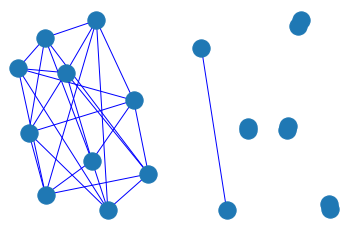

In [6]:
A1 = np.zeros([5,5])

A1[0] = [13, 5,89,45,12]
A1[1] = [45,71, 6,26,54]
A1[2] = [ 5,16,45,38,34]
A1[3] = [15, 7,48,52, 8]
A1[4] = [45,61,12, 1, 9]

G1 = nx.Graph()
for i in range(5):
    for j in range(5):
        G1.add_weighted_edges_from([('p'+str(i),'q'+str(j),A1[i][j])])

plt.subplot(121)
nx.draw(G1, nodecolor='r', edge_color='b')

B = hungarianAlgorithm(A1)
print(B)
G2 = nx.Graph()

for j in range(5):
    G2.add_weighted_edges_from([('p'+str(B[j][0]),'q'+str(B[j][1]),A1[i][j])])
plt.subplot(1,2,2)
nx.draw(G2, nodecolor='r', edge_color='b',sorted_axis = -1)

## Apareamiento de formas

Ahora procederemos a mostrar el algoritmo de apareamiento de figuras, haciendo la observación de que no usaremos el algoritmo húngaro implementado anteriormente pues tiene complejidad cuártica. En su lugar usaremos la implementación del paquete Networkx, usando la función de máximos pesos. Tendremos que tener cuidado de modificar los valores de la matriz, pues este algoritmo no admite números negativos y encuentra un máximo en vez de un mínimo. 

In [7]:
def hungarianAlgorithm(A):
    G = nx.Graph()
    edgeWList = []
    maxValue = max([max(A[i]) for i in range(len(A))])
    for i in range(len(A)):
        edgeWList.append([])
        for j in range(len(A)):
            edgeWList[i].append(('p'+str(i),'q'+str(j),maxValue-A[i][j]))
    for i in range(len(A)):
        G.add_weighted_edges_from(edgeWList[i])
    matchSet = nx.max_weight_matching(G)
    matchIndex = [ (int(Edge[0][1:]),int(Edge[1][1:])) for Edge in matchSet]
    return matchIndex



A continuación se muestra la función `histograma`. La cual, usando cajas log-polares, cuenta la cantidad de puntos en cada caja, con respecto a cada punto en un contorno. Este histograma representa lo que se conocerá como _contexto de figura_ , el cuál nos dará un preámbulo de comparación entre dos figuras.

In [8]:
def norm(p,q):
    N = ( (p[0]-q[0])**2 + (p[1]-q[1])**2 )**(0.5)
    #print(N)
    return N

def histograma(i,P):
    radBins = 8        # Cantidad de cajas radiales (anillos)
    angleBins = 15      # Cantidad de cajas angulares (quesitos)
    PA = 1.0*(np.copy(P))
    """
    X =[0,0]
    for i in range(len(PA)):
        X[0] += 1.0*PA[i][0]/len(PA)
        X[1] += 1.0*PA[i][1]/len(PA)
    """
    # Normaliza la forma con centro en X
    Z = P[i]
    #print(PA)
    Max = max([norm(P[j],Z) for j in range(len(P))])
    for j in range(len(PA)):
        a = float(P[j][0]-Z[0])
        b = float(P[j][1]-Z[1])
        PA[j][0] = a/(Max+1)
        PA[j][1] = b/(Max+1)
    # Inicializa el histograma
    H = np.zeros([radBins,angleBins])

    # Llena los bins (matriz de presencia)
    for j in range(len(PA)):
        if(j != i):
            theta = np.arctan2(PA[j][1],PA[j][0])
            r = norm(PA[i],PA[j])*(2**(radBins))
            #print(theta)
            if(r != 0):
                if np.log2(r) < 0:
                    H[0][int(1.0*angleBins*((theta+np.pi)%(2*np.pi))/(2*np.pi))] += 1.0
                else:
                    H[int(np.log2(r))][int(1.0*angleBins*((theta+np.pi)%(2*np.pi))/(2*np.pi))] += 1.0
    return H/float(sum(sum(H)))

A contunuación calcularemos lo que se conoce como *función de costos* que tiene como objetivo traducir la información de los histogramas a un número real. Mientras más alto sea este número, mayor será el "costo", lo que quiere decir que las figuras se parecen menos entre esos dos puntos.

In [9]:
def costFunction(ptInFirstShape,ptInSecondShape,H):
    #print(shape2)

    H1 = H[0][ptInFirstShape]
    H2 = H[1][ptInSecondShape]

    C = 0
    for k1 in range(len(H1)):
        for k2 in range(len(H1[0])):
            if H1[k1][k2]+H2[k1][k2] != 0:
                C += ((H1[k1][k2]-H2[k1][k2])**2)/(H1[k1][k2]+H2[k1][k2])
    return C/2.0


Una matriz de histogramas.

In [10]:
def calculaHistogramas(X,Y):
    size = len(X)
    H = [[],[]]
    for i in range(size):
        H[0].append(histograma(i,X))
        H[1].append(histograma(i,Y))
    return H


Las funciones `shapeContext` y `shapenorm` son las que juntan todas las herramientas que hemos construido. La primera calcula una matriz de costos, basándose en la matriz de histogramas anterior. La segunda normaliza los contornos para que tengan la misma cantidad de puntos, luego usa las funciones anteriores para encontrar la matriz de costos y de ésta resolver el problema de asignación, para hallar las parejas de puntos más óptimas usando `hungarianAlgorithm`. Finalmente calcula la distancia entre las figuras al sumar y normalizar los costos de las parejas óptimamente asignadas.

In [11]:
def shapeContext(X, Y):
    size = len(X)
    C = np.zeros([size,size])
    #print(X, Y)

    H = calculaHistogramas(X,Y)

    for i in range(size):
        for j in range(size):
            C[i][j] = costFunction(i,j,H)
    return C

def shapenorm(X,Y):
    sizeX = len(X)
    sizeY = len(Y)
    size = 0
    if sizeX > sizeY:
        for _ in range(sizeX-sizeY):
            Y.append(Y[0])
        size = sizeX
    elif sizeY > sizeX:
        for _ in range(sizeY-sizeX):
            X.append(X[0])
        size = sizeY
    else: size = sizeX


    C = shapeContext(X,Y)
    A = hungarianAlgorithm(C)
    norm = 0
    for (i,j) in A:
        norm += C[i-1][j-1]/(size)
    return [A,norm]


# Un ejemplo. 20 imágenes.

A continuación se compararán 20 contornos provenientes del paquete de control `hmm_gpd`. La función `saveNormVector` compara una figura fija con otras 20, imprime los tiempos que se tardó en cada comparación, guarda en un archivo los tiempos y finalmente muestra gráficamente la asignación de la comparación más parecida.

In [12]:
def saveNormVector(fixedIndex,scale=10):
        Normas = []
        auxMin = 10000
        index2 = 0
        cosa1 = np.array(sio.loadmat("data/"+str(fixedIndex)+".mat")['x'])
        for k in range(fixedIndex+1,23):
            cosa2 = np.array(sio.loadmat("data/"+str(k)+".mat")['x'])

            Dis1 = len(cosa1)
            Dis2 = len(cosa2)

            scale1 = scale
            scale2 = scale
            if Dis1 > Dis2:
                for i in range(scale):
                    if Dis1//scale <= Dis2//(scale-i):
                        break
                    else: scale2 = (scale-i)
            elif Dis1 < Dis2:
                for i in range(scale):
                    if Dis2//scale <= Dis1//(scale-i):
                        break
                    else: scale1 = (scale-i)
            print(Dis1//scale1,Dis2//scale2)

            t1 = t.time()
            Res = shapenorm([[int(cosa1[i][0]),int(cosa1[i][1])] for i in range(0,len(cosa1),scale1)],[[int(cosa2[i][0]),int(cosa2[i][1])] for i in range(0,len(cosa2),scale2)])
            t2 = t.time()


            A = Res[0]
            dist = Res[1]
            Normas.append(dist)
            if auxMin > dist:
                auxMin =  dist
                index2 = k

            print('La distancia entre las imágenes '+str(fixedIndex)+' y '+str(k)+' es: ', dist)
            print("Se tardó ", t2-t1, " segundos")
        file = open('LasDistancias'+str(fixedIndex)+'.txt',"w+")
        for k in range(len(Normas)):
            file.write("D("+str(j)+","+str(k+fixedIndex)+") = "+str(Normas[k])+"\n")
        file.close()
        
        cosa1 = np.array(sio.loadmat("data/"+str(fixedIndex)+".mat")['x'])
        cosa2 = np.array(sio.loadmat("data/"+str(index2)+".mat")['x'])
        
        Res = shapenorm([[int(cosa1[i][0]),int(cosa1[i][1])] for i in range(0,len(cosa1),scale1)],[[int(cosa2[i][0]),int(cosa2[i][1])] for i in range(0,len(cosa2),scale2)])

        A = Res[0]
        dist = Res[1]
        Pl = []

        for i in range(len(A)):
            try:
                Pl.append((cosa1[scale1*A[i][1]-scale1][0],cosa1[scale1*A[i][1]-scale1][1]))
            except: Pl.append((cosa1[0][0],cosa1[0][1]))
            try:
                Pl.append((cosa2[scale2*A[i][0]-scale2][0],cosa2[scale2*A[i][0]-scale2][1]))
            except: Pl.append((cosa2[0][0],cosa2[0][1]))
        for i in range(0,len(Pl),2):
            plt.subplot(1,1,1),plt.plot([Pl[i][0],Pl[i+1][0]],[Pl[i][1],Pl[i+1][1]], '--')

        plt.subplot(1,1,1),plt.plot(cosa1[:,0],cosa1[:,1],'.b')
        plt.subplot(1,1,1),plt.plot(cosa2[:,0],cosa2[:,1],'.r')

        plt.show()

        
        return Normas

Finalmente, con una escala de 1 a 20 (para no llevarnos toda la vida), hacemos la comparación de 5 figuras con otras 20. Para acelerar el proceso usaremos la librería `multiprocessing` para realizar estas pruebas. Se asume que el usuario tiene al menos 4 núcleos en su procesador. Si no es así, el algoritmo se ejecutará sin problemas, pero tomará más tiempo.

30 31
17 16
25 26
17 17
La distancia entre las imágenes 3 y 4 es:  0.7551737793694207
Se tardó  0.17838168144226074  segundos
17 16
La distancia entre las imágenes 4 y 5 es:  0.7178563187628377
Se tardó  0.2647216320037842  segundos
24 26
La distancia entre las imágenes 3 y 5 es:  0.3736930757151346
Se tardó  0.17228102684020996  segundos
24 26
La distancia entre las imágenes 5 y 6 es:  0.4727277341779021
Se tardó  0.5832099914550781  segundos
29 31
La distancia entre las imágenes 6 y 7 es:  0.5317806974968884
Se tardó  0.7801930904388428  segundos
26 25
La distancia entre las imágenes 4 y 6 es:  0.5837992880502332
Se tardó  0.6100614070892334  segundos
28 31
La distancia entre las imágenes 3 y 6 es:  0.4812211962457169
Se tardó  0.5391125679016113  segundos
30 31
La distancia entre las imágenes 6 y 8 es:  0.499831450349326
Se tardó  0.5634469985961914  segundos
28 29
La distancia entre las imágenes 5 y 7 es:  0.2686255636371061
Se tardó  0.9294672012329102  segundos
19 20
La distancia

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

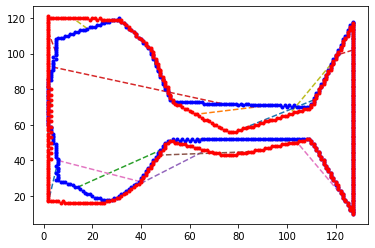

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

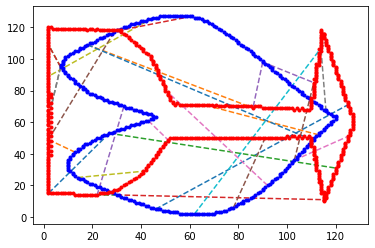

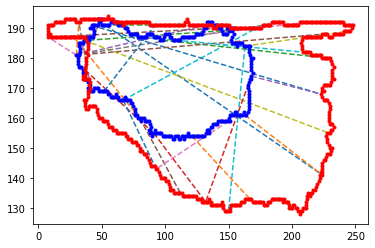

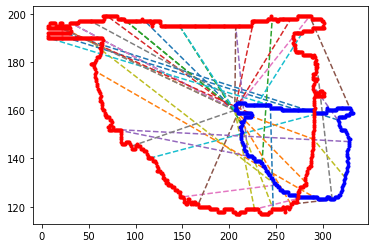

17 16
25 26
30 31
31 29
La distancia entre las imágenes 4 y 5 es:  0.7178563187628377
Se tardó  0.26038551330566406  segundos
24 26
La distancia entre las imágenes 5 y 6 es:  0.4727277341779021
Se tardó  0.5815184116363525  segundos
29 31
La distancia entre las imágenes 6 y 7 es:  0.5317806974968884
Se tardó  0.8745229244232178  segundos
26 25
La distancia entre las imágenes 4 y 6 es:  0.5837992880502332
Se tardó  0.6585066318511963  segundos
28 31
La distancia entre las imágenes 7 y 8 es:  0.2897727103607372
Se tardó  1.0792560577392578  segundos
31 30
La distancia entre las imágenes 6 y 8 es:  0.499831450349326
La distancia entre las imágenes 5 y 7 es:  0.2686255636371061
Se tardó  0.8350601196289062  segundos
Se tardó  0.553107738494873  segundos
19 20
28 29
La distancia entre las imágenes 5 y 8 es:  0.2787663535644639
Se tardó  0.3238954544067383  segundos
27 29
La distancia entre las imágenes 7 y 9 es:  0.6424725857438182
Se tardó  0.7812051773071289  segundos
31 29
La distancia e

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

La distancia entre las imágenes 4 y 21 es:  0.6091309663052886
Se tardó  1.4561407566070557  segundos
21 23
La distancia entre las imágenes 7 y 21 es:  0.16464231441854008
Se tardó  1.2620611190795898  segundos
31 29


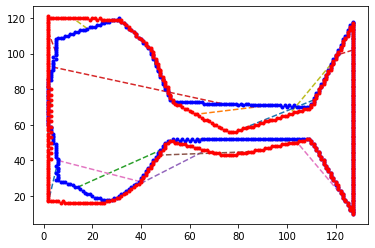

La distancia entre las imágenes 4 y 22 es:  0.6031281081769548
Se tardó  0.45444798469543457  segundos
La distancia entre las imágenes 7 y 22 es:  0.6503787741899939
Se tardó  0.8418080806732178  segundos


/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

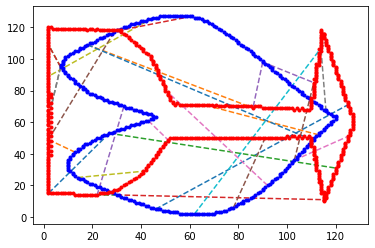

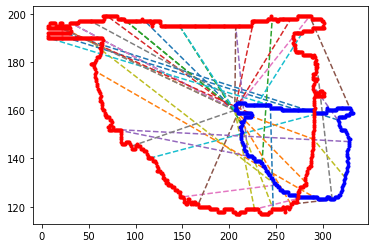

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

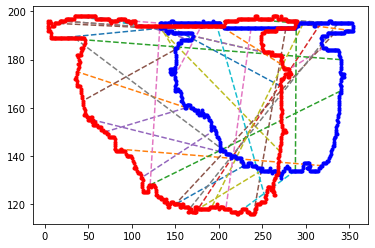

25 26
31 29
30 31
27 29
La distancia entre las imágenes 5 y 6 es:  0.4727277341779021
Se tardó  1.4976885318756104  segundos
29 31
La distancia entre las imágenes 7 y 8 es:  0.2897727103607372
Se tardó  1.6216356754302979  segundos
31 30
La distancia entre las imágenes 8 y 9 es:  0.6218732287974077
Se tardó  1.626072645187378  segundos
27 28
La distancia entre las imágenes 6 y 7 es:  0.5317806974968884
Se tardó  1.8427484035491943  segundos
26 25
La distancia entre las imágenes 8 y 10 es:  0.26930305972318863
Se tardó  0.6001191139221191  segundos
25 27
La distancia entre las imágenes 5 y 7 es:  0.2686255636371061
Se tardó  0.8737020492553711  segundos
19 20
La distancia entre las imágenes 6 y 8 es:  0.499831450349326
Se tardó  0.5355570316314697  segundos
28 29
La distancia entre las imágenes 7 y 9 es:  0.6424725857438182
Se tardó  0.9794902801513672  segundos
31 29
La distancia entre las imágenes 5 y 8 es:  0.2787663535644639
Se tardó  0.3520030975341797  segundos
27 29
La distancia 

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


La distancia entre las imágenes 7 y 20 es:  0.5818269973912409
Se tardó  0.7758827209472656  segundos
36 38


/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


La distancia entre las imágenes 5 y 22 es:  0.5581078264379691
Se tardó  0.40595340728759766  segundos
La distancia entre las imágenes 6 y 21 es:  0.500576184625536
Se tardó  1.4475998878479004  segundos
26 25


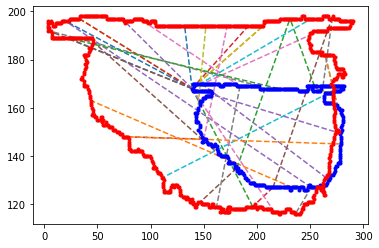

La distancia entre las imágenes 6 y 22 es:  0.4183894964546737
Se tardó  0.5244767665863037  segundos
La distancia entre las imágenes 7 y 21 es:  0.16464231441854008
Se tardó  1.3033068180084229  segundos
31 29


/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

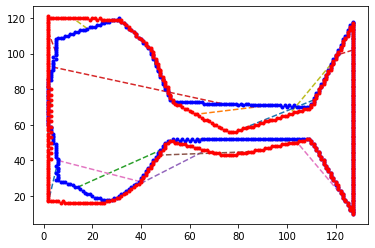

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


La distancia entre las imágenes 7 y 22 es:  0.6503787741899939
Se tardó  0.7057204246520996  segundos


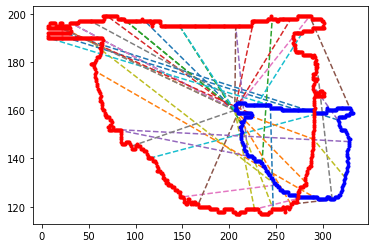

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

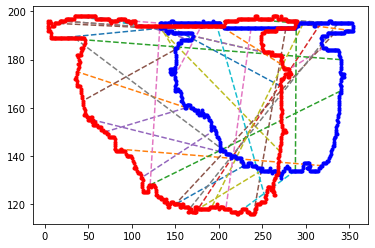

30 31
31 29
27 29
29 28
La distancia entre las imágenes 6 y 7 es:  0.5317806974968884
La distancia entre las imágenes 7 y 8 es:  0.2897727103607372
Se tardó  0.7805986404418945  segundos
26 25
Se tardó  0.7799618244171143  segundos
31 30
La distancia entre las imágenes 9 y 10 es:  0.6408360058658529
Se tardó  0.9049592018127441  segundos
29 28
La distancia entre las imágenes 8 y 9 es:  0.6218732287974077
Se tardó  0.9469153881072998  segundos
27 28
La distancia entre las imágenes 6 y 8 es:  0.499831450349326
Se tardó  0.5730817317962646  segundos
28 29
La distancia entre las imágenes 7 y 9 es:  0.6424725857438182
La distancia entre las imágenes 9 y 11 es:  0.1754412177389846
Se tardó  0.6418759822845459  segundos
Se tardó  0.7675039768218994  segundos
30 31
La distancia entre las imágenes 8 y 10 es:  0.26930305972318863
31 29
Se tardó  0.6434204578399658  segundos
25 27
La distancia entre las imágenes 6 y 9 es:  0.3833283870134772
Se tardó  0.8610949516296387  segundos
La distancia ent

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


La distancia entre las imágenes 6 y 21 es:  0.500576184625536
Se tardó  1.38981032371521  segundos
26 25


/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


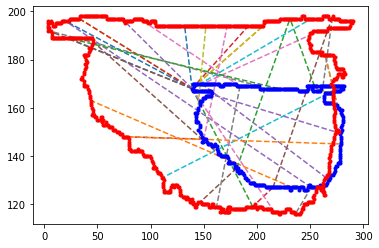

La distancia entre las imágenes 6 y 22 es:  0.4183894964546737
Se tardó  0.5411849021911621  segundos


/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

La distancia entre las imágenes 7 y 21 es:  0.16464231441854008
Se tardó  1.5014889240264893  segundos
31 29


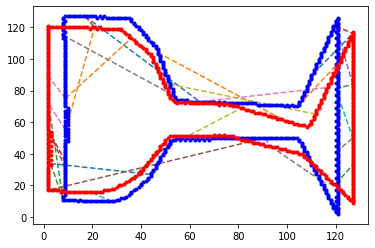

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

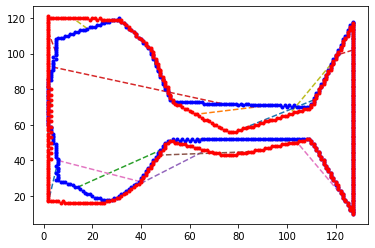

La distancia entre las imágenes 7 y 22 es:  0.6503787741899939
Se tardó  0.8033158779144287  segundos


/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

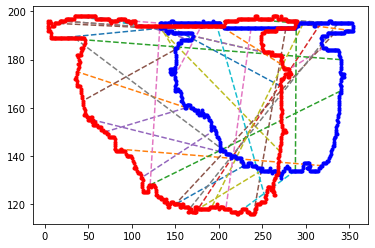

31 29
27 29
29 28
28 27
La distancia entre las imágenes 10 y 11 es:  0.5928625927561049
Se tardó  0.7171003818511963  segundos
29 31
La distancia entre las imágenes 9 y 10 es:  0.6408360058658529
La distancia entre las imágenes 8 y 9 es:  0.6218732287974077
Se tardó  0.7763397693634033  segundos
Se tardó  0.7960026264190674  segundos
La distancia entre las imágenes 7 y 8 es:  0.2897727103607372
29 28
Se tardó  0.8264656066894531  segundos
27 28
31 30
La distancia entre las imágenes 8 y 10 es:  0.26930305972318863
Se tardó  0.5813360214233398  segundos
La distancia entre las imágenes 9 y 11 es:  0.1754412177389846
25 27
Se tardó  0.6160383224487305  segundos
30 31
La distancia entre las imágenes 10 y 12 es:  0.2605319996478694
Se tardó  0.8346560001373291  segundos
28 27
La distancia entre las imágenes 7 y 9 es:  0.6424725857438182
Se tardó  0.9028935432434082  segundos
31 29
La distancia entre las imágenes 8 y 11 es:  0.5098374875334123
Se tardó  0.6100459098815918  segundos
29 31
La d

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

La distancia entre las imágenes 7 y 20 es:  0.5818269973912409
Se tardó  0.9609889984130859  segundos
36 38


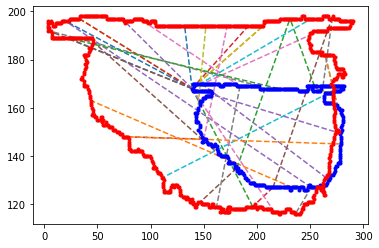

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

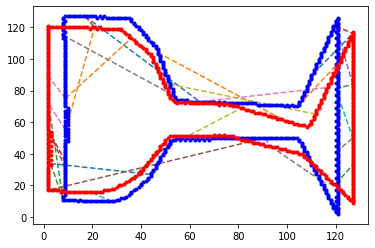

/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


La distancia entre las imágenes 7 y 21 es:  0.16464231441854008
Se tardó  1.3780598640441895  segundos
31 29


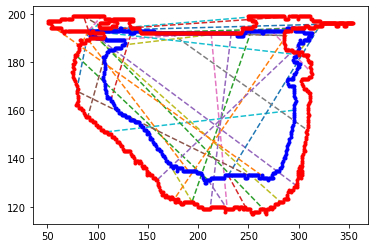

La distancia entre las imágenes 7 y 22 es:  0.6503787741899939
Se tardó  0.6933150291442871  segundos


/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/theStampedeDOTsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

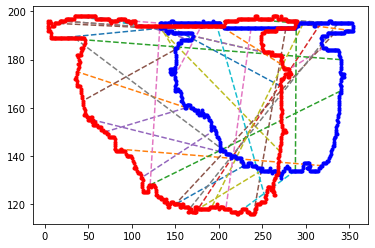

In [13]:
scale = 20
Normas = []
for J in range(5):
    with Pool(4) as P:
        aux = P.starmap(saveNormVector,[(J+3,scale),(J+4,scale),(J+5,scale),(J+6,scale)])
        for k in range(4):
            Normas.append(aux[k])

Podemos ver que de la carpeta `data`, nuestro algoritmo no sólo fue capaz de distinguir copas de copas y autos de autos, sino que lo hizo con un criterio bastante bueno.